In [2]:
library(tidyverse)
library(class)
library(caret)
library(lubridate)
library(ggplot2)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(recipes)


# Load Players Dataset
url_player <- "https://drive.google.com/uc?id=1pD2UbBtMG1NHjlCo4HYVrvy72jilNUv-"
download.file(url_player, destfile = "players.csv")
players <- read_csv("players.csv")

players <- players |> mutate(subscribe = as.factor(subscribe), experience = as.factor(experience))

players

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conf

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
set.seed(3456) 
#Split data

players_split <- initial_split(players, prop = 0.80, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)



In [6]:
set.seed(3956) 

#recipe
players_recipe <- recipe(subscribe ~ experience, data = players_train) |>
    step_dummy(experience)
players_recipe
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 1



── Operations 

• Dummy variables from: experience



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,accuracy,binary,0.4229839,5,0.03081711,Preprocessor1_Model01
10,roc_auc,binary,0.5455918,5,0.02683888,Preprocessor1_Model01
11,accuracy,binary,0.4294355,5,0.02143175,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
39,roc_auc,binary,0.4753019,5,0.014075490,Preprocessor1_Model30
40,accuracy,binary,0.7372984,5,0.004637097,Preprocessor1_Model31
40,roc_auc,binary,0.4764493,5,0.023229767,Preprocessor1_Model31


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,accuracy,binary,0.4229839,5,0.03081711,Preprocessor1_Model01
11,accuracy,binary,0.4294355,5,0.02143175,Preprocessor1_Model02
12,accuracy,binary,0.4294355,5,0.02143175,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
38,accuracy,binary,0.7372984,5,0.004637097,Preprocessor1_Model29
39,accuracy,binary,0.7372984,5,0.004637097,Preprocessor1_Model30
40,accuracy,binary,0.7372984,5,0.004637097,Preprocessor1_Model31


[1] 31

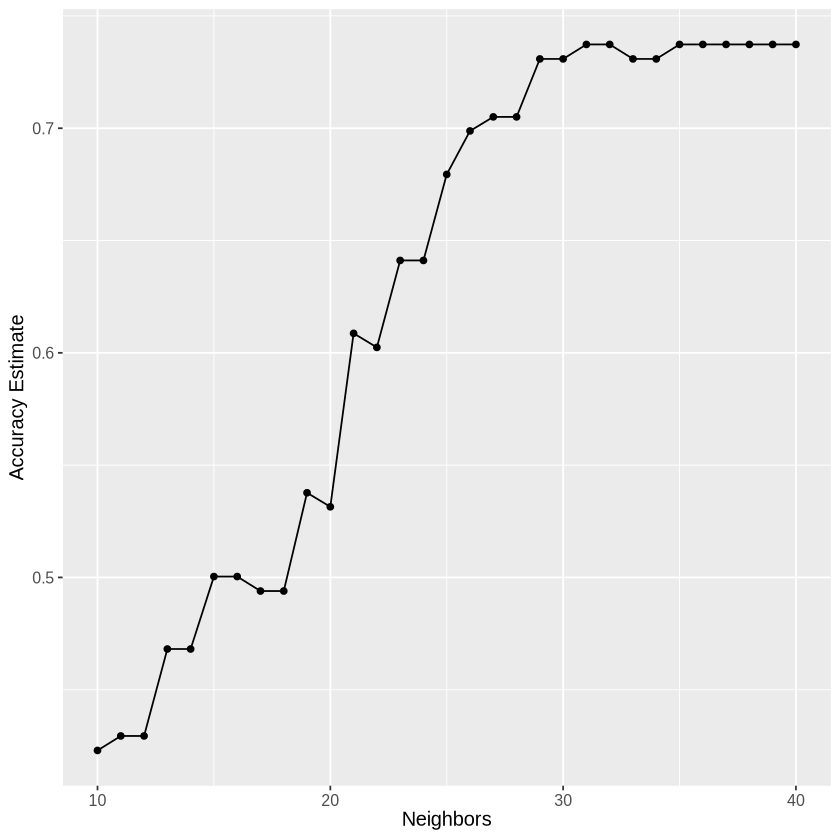

In [25]:
set.seed(2020) # DO NOT REMOVE


players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)



players_vfold_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = players_vfold)


players_metrics <- collect_metrics(players_vfold_fit)


knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 10, to = 40, by = 1))

knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

knn_results

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

In [23]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

knn_fit

players_test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

players_test_predictions 

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(31,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2628205
Best kernel: rectangular
Best k: 31

.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<fct>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
TRUE,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
TRUE,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
TRUE,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
TRUE,Amateur,TRUE,9955ab948064150d3686ef564389bdc6d6c60bc620a5ce3084b3dec4a7a006a7,0.4,Charlie,Two-Spirited,17
TRUE,Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
TRUE,Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.675
